# Example 5.12 (A control ellipse for future overtime hours)

In [1]:
import pathlib
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chapter_5_utils import plot_future_control_ellipse

In [2]:
def load_data() -> pd.DataFrame:
    fpth = pathlib.Path(r'..\..\data\Table5.8.xlsx')
    return pd.read_excel(fpth)

In [3]:
overtime_df = load_data()[['Legal Appearances Hours', 'Extraordinary Event Hours']]
overtime_df.head(3)

,Legal Appearances Hours,Extraordinary Event Hours
0,3387,2200
1,3109,875
2,2670,957


In [4]:
# X is n x p = 16 x 2.
X = overtime_df.to_numpy()

# Remove observation 11.
X = np.delete(X, 10, axis=0)
n, p = X.shape

In [6]:
xbar = np.mean(X, axis=0).reshape(p, 1)
S = np.cov(X.T, ddof=1)

In [12]:
alpha = 0.05
crit = (((n-1)*p)/(n-p))*scipy.stats.chi2(df=p).ppf(q=1-alpha)

Compute $T^{2} = \frac{n}{n + 1} {\left(\textbf{x} - \bar{\textbf{x}}\right)}^{\prime} \textbf{S}^{-1} {\left(\textbf{x} - \bar{\textbf{x}}\right)}$

In [14]:
Sinv = np.linalg.inv(S)
stat_dist = lambda x: (n/(n + 1)) * (x.reshape(1,p) - xbar.T) @ Sinv @ (x.reshape(p,1) - xbar)
dist = np.array([stat_dist(X[i,:]).flatten() for i in range(X.shape[0])])

How many values are larger than $\frac{(n-1)p}{(n-p)} F_{p=2, n-p = 13}\left(0.05\right)$?

In [15]:
print(f'There are {(dist > crit).sum()} observations larger than {crit:.2f}.')

There are 0 observations larger than 12.90.


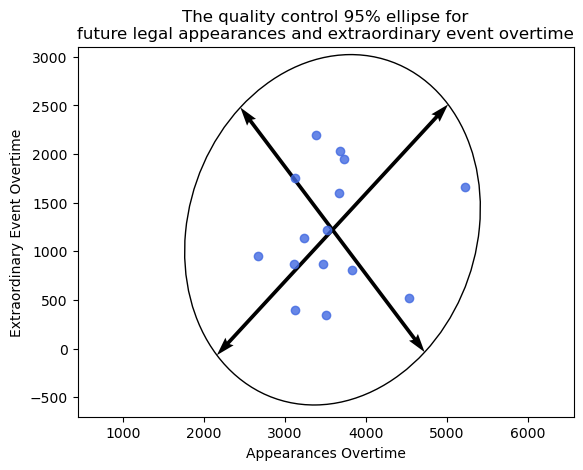

In [26]:
my_plot, ax = plot_future_control_ellipse(X, n, p, 0.05)
my_plot.scatter(X[:,0],
                X[:,1],
                facecolors='royalblue', edgecolors='royalblue', alpha=0.8)
ax.set_aspect('equal')
ax.set_xlim(1500, 5500)
ax.set_ylim(-700, 3100)
# ax.set_aspect(aspect=1.2, adjustable='datalim')
ax.set_title('The quality control 95% ellipse for\nfuture legal appearances and extraordinary event overtime')
my_plot.xlabel('Appearances Overtime')
my_plot.ylabel('Extraordinary Event Overtime')
my_plot.show()